In [ ]:
#|default_exp utils 

In [ ]:
#| export
import pickle,gzip,math,os,time,shutil,torch,matplotlib as mpl,numpy as np,matplotlib.pyplot as plt
import fastcore.all as fc
from collections.abc import Mapping
from pathlib import Path
from operator import attrgetter,itemgetter
from functools import partial
from copy import copy
from contextlib import contextmanager

import torchvision.transforms.functional as TF,torch.nn.functional as F
from torch import tensor,nn,optim
from torch.utils.data import DataLoader,default_collate
from torch.nn import init
from torch.optim import lr_scheduler
from torcheval.metrics import MulticlassAccuracy
from datasets import load_dataset,load_dataset_builder


from miniai.datasets import *
from miniai.conv import *
from miniai.learner import *
from miniai.activations import *
from miniai.mps import *

## Reseed CB
This callback facilitate using different seeds while still keeping the training reproducable by reporting the seed on each use.

In [ ]:
#| export
class ReseedCB(Callback):
    order = 0
    def __init__(self): self.gen, self.new_seed = torch.Generator(), None
    def before_fit(self, learn): 
        self.set_seed(self.new_seed)
        print('Using seed', self.new_seed)
    def set_seed(self, seed=None): 
        if seed is None: 
            self.new_seed = torch.randint(2**31, [1], generator=self.gen).item()
            print(f"New seed: {self.new_seed}")
        else:
            self.new_seed = seed
        set_seed(self.new_seed)
        return self.new_seed
    def previous(self): self.set_seed(self.new_seed)
    def new(self): self.set_seed()

In [ ]:
reseed=ReseedCB()

Seed is set twice, on pervious|new|set_seed and before every seed

In [ ]:
reseed.before_fit(None)
print(torch.randn(10))
reseed.before_fit(None)
print(torch.randn(10))

New seed: 205811062
Using seed 205811062
tensor([-0.5644, -1.8079,  0.5900,  0.6734,  0.0040, -0.6066, -0.3101,  0.8848,
         0.0541,  0.3965])
Using seed 205811062
tensor([-0.5644, -1.8079,  0.5900,  0.6734,  0.0040, -0.6066, -0.3101,  0.8848,
         0.0541,  0.3965])


In [ ]:
reseed.previous()
print(torch.randn(10)) # useful during init
reseed.before_fit(None)
print(torch.randn(10))

tensor([-0.5644, -1.8079,  0.5900,  0.6734,  0.0040, -0.6066, -0.3101,  0.8848,
         0.0541,  0.3965])
Using seed 205811062
tensor([-0.5644, -1.8079,  0.5900,  0.6734,  0.0040, -0.6066, -0.3101,  0.8848,
         0.0541,  0.3965])


In [ ]:
reseed.set_seed(42)
print(torch.randn(10))
reseed.before_fit(None)
print(torch.randn(10))

tensor([ 0.3367,  0.1288,  0.2345,  0.2303, -1.1229, -0.1863,  2.2082, -0.6380,
         0.4617,  0.2674])
Using seed 42
tensor([ 0.3367,  0.1288,  0.2345,  0.2303, -1.1229, -0.1863,  2.2082, -0.6380,
         0.4617,  0.2674])


In [ ]:
reseed.new()
print(torch.randn(10))
reseed.before_fit(None)
print(torch.randn(10))

New seed: 1155489284
tensor([ 0.1857,  0.5785,  0.1219, -0.4333, -0.8358, -0.3888, -1.5829, -0.6018,
         0.2697,  0.2101])
Using seed 1155489284
tensor([ 0.1857,  0.5785,  0.1219, -0.4333, -0.8358, -0.3888, -1.5829, -0.6018,
         0.2697,  0.2101])


## Speed of Training

Unfortunately the multiprocessing is a bit slower on MPS as the main process has to share the number of OMP Threads (the value cannot be changed after fork). So to avoid warnings it is set to 1. Which makes the dataloader a bit slower.  To workaround this i've added cache_dataset_as_dict

It improves the performance 4x for large batch sizes from:
- 16 sec per fit(5)

to:

- 5 sec initial loading time
- 3.6 sec per fit(5)

In [ ]:
import pickle,gzip,math,os,time,shutil,torch,matplotlib as mpl,numpy as np,matplotlib.pyplot as plt
import fastcore.all as fc
from collections.abc import Mapping
from pathlib import Path
from operator import attrgetter,itemgetter
from functools import partial
from copy import copy
from contextlib import contextmanager

import torchvision.transforms.functional as TF,torch.nn.functional as F
from torch import tensor,nn,optim
from torch.utils.data import DataLoader,default_collate
from torch.nn import init
from torch.optim import lr_scheduler
from torcheval.metrics import MulticlassAccuracy
from datasets import load_dataset,load_dataset_builder

from miniai.datasets import *
from miniai.conv import *
from miniai.learner import *
from miniai.activations import *
from miniai.init import get_model, init_weights

In [ ]:
#| export
import time

def _format_stats(stats):
    return f"{stats.mean():.2f} ± {stats.std():.2f}"

class TimeItCB(Callback):
    def __init__(self):
        self.reset()
    def tick(self): return time.time()
         
    def reset(self):
        self.start = self.tick()
        self.setup = None
        self.batches = {True:[], False:[]}
        self.epochs = {True:[], False:[]}
        self.samples = {True:[], False:[]}
    def before_fit(self, learn):
        self.reset()
        
    def before_batch(self, learn):
        if self.setup is None: self.setup = self.tick() - self.start
        self.batches[learn.training].append(self.tick())
    
    def after_batch(self, learn):
        self.batches[learn.training][-1] = self.tick() - self.batches[learn.training][-1]
        self.samples[learn.training].append(learn.batch[0].shape[0])
    
    def before_epoch(self, learn):
        self.epochs[learn.training].append(self.tick())
    
    def after_epoch(self, learn):
        self.epochs[learn.training][-1] = self.tick() - self.epochs[learn.training][-1]
    
    def after_fit(self, learn):
        self.total = self.tick() - self.start
        self.setup = self.setup / self.total
        self.batches = {k:np.array(v) for k,v in self.batches.items()}
        self.epochs = {k:np.array(v) for k,v in self.epochs.items()}
        self.samples = {k:np.array(v) for k,v in self.samples.items()}
        self.print_stats()
    
    def print_stats(self): 
        print(f"Fit {len(self.epochs[True])} in: {self.total:.2f}s, setup: {self.setup:.2f}s, {_format_stats(self.epochs[True])}s per epoch, {_format_stats(self.batches[True])}s per batch")
        #print(f" samples/sec: {self.samples[True].sum() / self.total:.2f}s, time_in_val: {self.epochs[False].sum() / self.total:.2f}s")

In [ ]:
#| export
# if spawn is not possible, we can cache the entire dataset in memory after transformations
def _with_features(ds):
    setattr((l:=fc.L(ds)), 'features', ds.features)
    return l 
def cache_dataset_as_dict(dd): return {dsn: _with_features(ds) for dsn,ds in dd.items()}

In [ ]:
metrics = MetricsCB(accuracy=MulticlassAccuracy())
cbs = [DeviceCB(), metrics, ProgressCB(plot=True), TimeItCB()]

In [ ]:
bs = 1024*16
xmean, xstd = 0.28, 0.35
name = "fashion_mnist"
def to_tensor_tfm(b, mean, std, xl='image'): 
    b[xl] = [(TF.to_tensor(o)-mean)/std for o in b[xl]]
    return b

dsd = load_dataset(name)
tds = dsd.with_transform(partial(to_tensor_tfm, mean=xmean, std=xstd))

Found cached dataset fashion_mnist (/home/pczapla/.cache/huggingface/datasets/fashion_mnist/fashion_mnist/1.0.0/8d6c32399aa01613d96e2cbc9b13638f359ef62bb33612b077b4c247f6ef99c1)


  0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
dls = DataLoaders.from_dd(tds, bs, num_workers=4, )
set_seed(42)
learn = TrainLearner(get_model().to('cpu').apply(init_weights), dls, F.cross_entropy, lr=1e-2, cbs=cbs, opt_func=optim.AdamW)

accuracy,loss,epoch,train
0.353,2.062,0,train
0.578,1.217,0,eval
0.655,0.978,1,train
0.724,0.778,1,eval
0.729,0.764,2,train
0.765,0.654,2,eval
0.775,0.621,3,train
0.782,0.605,3,eval
0.793,0.564,4,train
0.791,0.559,4,eval


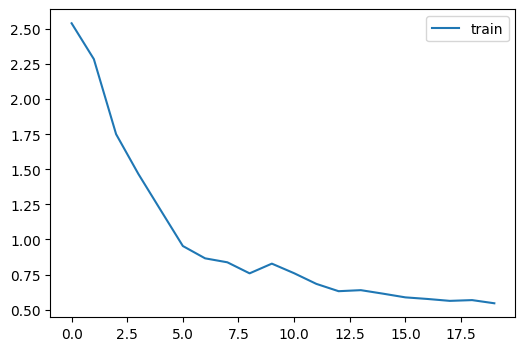

Fit 5 in: 95.21s, setup: 0.04s, 16.49 ± 1.52s per epoch, 0.23 ± 0.76s per batch


In [ ]:
learn.fit(5)

In [ ]:
%%timeit -n 1 -r 1
tds.cached = cache_dataset_as_dict(tds)

15.6 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [ ]:
set_seed(42)
dls_cached = DataLoaders.from_dd(tds.cached, bs, num_workers=0)
learn = TrainLearner(get_model().to('cpu').apply(init_weights), dls_cached, F.cross_entropy, lr=1e-2, cbs=cbs, opt_func=optim.AdamW)

accuracy,loss,epoch,train
0.353,2.062,0,train
0.578,1.217,0,eval
0.655,0.978,1,train
0.724,0.778,1,eval
0.730,0.764,2,train
0.765,0.654,2,eval
0.775,0.621,3,train
0.782,0.605,3,eval
0.793,0.564,4,train
0.792,0.559,4,eval


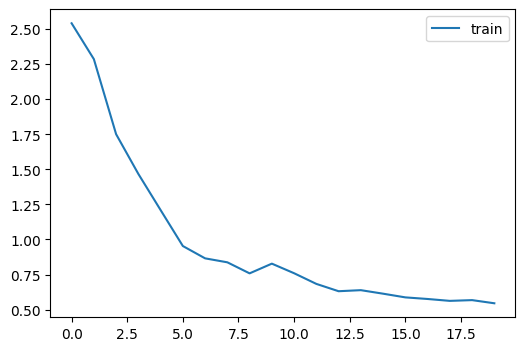

Fit 5 in: 4.65s, setup: 0.01s, 0.87 ± 0.09s per epoch, 0.06 ± 0.01s per batch


In [ ]:
learn.fit(5)

In [ ]:
len(tds.cached['train']), bs

(60000, 16384)

## Export

In [ ]:
import nbdev; nbdev.nbdev_export()